In [2]:
 %run /Desktop/Share/CUDA_DEVICE_setup.py -n 1

using GPU ID:0,



In [3]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [4]:
#%config Completer.use_jedi = False

import sys
sys.path.append('..')


from pprint import pprint    
import tensorflow as tf    
from collections import defaultdict
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

from tndm.data import DataManager
from tndm import LFADS
from tndm.runtime import Runtime
from typing import Dict, Any
from sklearn.linear_model import Ridge

from plotting import *

2023-07-12 15:07:50.592225: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-12 15:07:50.643267: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-12 15:07:51.424924: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
# read the data/disk/scratch/cole/Chewie_CO_FF_2016-10-07_pos_M1_spikes/test_data/
spike_data_dir = "Chewie_CO_FF_2016-10-07_pos_M1_spikes/"

data_dir = os.path.join( spike_data_dir )

dataset, settings = DataManager.load_dataset(
    directory=data_dir,
    filename='dataset.h5')

#train
neural_data = dataset['train_data'].astype('float')
behavioural_data = dataset['train_behaviours'].astype('float')

# valid
valid_neural_data = dataset['valid_data'].astype('float')
valid_behavioural_data = dataset['valid_behaviours'].astype('float')

# test
test_neural_data = dataset['test_data'].astype('float')
test_behavioural_data = dataset['test_behaviours'].astype('float')

# get dataset, to train by myself
# with_behaviour = False for lfads
# target = input for reconstruction

In [18]:
(x_train, y_train), (x_val, y_val) = Runtime.clean_datasets(
            train_dataset=(neural_data, behavioural_data), 
            val_dataset=(valid_neural_data, valid_behavioural_data), 
            with_behaviour=False
            )

In [19]:
x_test = test_neural_data
y_test = test_behavioural_data

In [20]:
def print_data_shape(data):
    if data is not None:
        print(data.shape)
    else:
        print("None")

In [21]:
print_data_shape(x_train)
print_data_shape(y_train)
print_data_shape(x_val)
print_data_shape(y_val)
print_data_shape(x_test)
print_data_shape(y_test)

(136, 73, 70)
None
(17, 73, 70)
None
(17, 73, 70)
(17, 73, 2)


# Quantize data first
## the input and last layer will remain ap<16,6> precision

In [22]:
AP_BITS = 16
AP_INTS = 6

In [23]:
# ususal quantize
from qkeras import QActivation
ACTIVATION_BITS = "quantized_bits(16,5,alpha=1)".format(AP_BITS, AP_INTS-1)

## change to quantize inputs only

In [24]:
# see mae after quanitze
from sklearn.metrics import mean_absolute_error

In [25]:
#total_data = [x_train, y_train, x_val, y_val, x_test, y_test]
total_data = [x_train, x_val, x_test]

for index, d in enumerate(total_data):
    print("index: ", index)
    if d is None:
        print("None")
    else:                
        print("before quantization min/max: {} / {}".format(d.min(), d.max()))
        q_d = QActivation(ACTIVATION_BITS)(d)
        q_d_numpy = q_d.numpy()
        print("after quantization min/max: {} / {}".format(q_d_numpy.min(), q_d_numpy.max()))
        print("MAE of quantization: ", mean_absolute_error(d.flatten(), q_d_numpy.flatten()))
        total_data[index] = q_d_numpy
    
#[x_train, y_train, x_val, y_val, x_test, y_test] = total_data    
[x_train, x_val, x_test] = total_data    

index:  0
before quantization min/max: 0.0 / 3.0
after quantization min/max: 0.0 / 3.0
MAE of quantization:  0.0
index:  1
before quantization min/max: 0.0 / 3.0
after quantization min/max: 0.0 / 3.0
MAE of quantization:  0.0
index:  2
before quantization min/max: 0.0 / 3.0
after quantization min/max: 0.0 / 3.0
MAE of quantization:  0.0


# model parameters

In [26]:
# model parameters

# l2 regulariser for the recurrent decoder weights
l2_reg = .1
#initial_neural_weight = 1.0 # weight of neural nll
#initial_behaviour_weight = .2 # weight of behaviour loss
#lambda_q = 100.0
#update_rate = .0005
dropout = .15
#seed = 0
#GRU_pre_activation = False
#var_min = 0.0001
#prior_variance = 1
threshold_poisson_log_firing_rate = 100.


layers_settings=defaultdict(lambda: dict(
    kernel_initializer=tf.keras.initializers.VarianceScaling(
        scale=1.0, mode='fan_in', distribution='normal'),
    kernel_regularizer=tf.keras.regularizers.l2(l=0.0)
))

layers_settings['decoder'].update(dict(kernel_regularizer=tf.keras.regularizers.l2(l=0),
                                      recurrent_regularizer=tf.keras.regularizers.l2(l=l2_reg),
                                      original_cell=False))    

In [27]:
pprint(layers_settings)

defaultdict(<function <lambda> at 0x7f12ac0be310>,
            {'decoder': {'kernel_initializer': <keras.initializers.initializers.VarianceScaling object at 0x7f12ad6bb4f0>,
                         'kernel_regularizer': <keras.regularizers.L2 object at 0x7f12ad6bb340>,
                         'original_cell': False,
                         'recurrent_regularizer': <keras.regularizers.L2 object at 0x7f12ad6bbc40>}})


In [28]:
layers_settings['encoder']

{'kernel_initializer': <keras.initializers.initializers.VarianceScaling at 0x7f12ad6a8b80>,
 'kernel_regularizer': <keras.regularizers.L2 at 0x7f12ad6a8d90>}

In [29]:
layers_settings['decoder']

{'kernel_initializer': <keras.initializers.initializers.VarianceScaling at 0x7f12ad6bb4f0>,
 'kernel_regularizer': <keras.regularizers.L2 at 0x7f12ad6bb340>,
 'recurrent_regularizer': <keras.regularizers.L2 at 0x7f12ad6bbc40>,
 'original_cell': False}

In [30]:
layers_settings['dense_mean']

{'kernel_initializer': <keras.initializers.initializers.VarianceScaling at 0x7f12ad6a8bb0>,
 'kernel_regularizer': <keras.regularizers.L2 at 0x7f12ad6a8910>}

## function to build the model

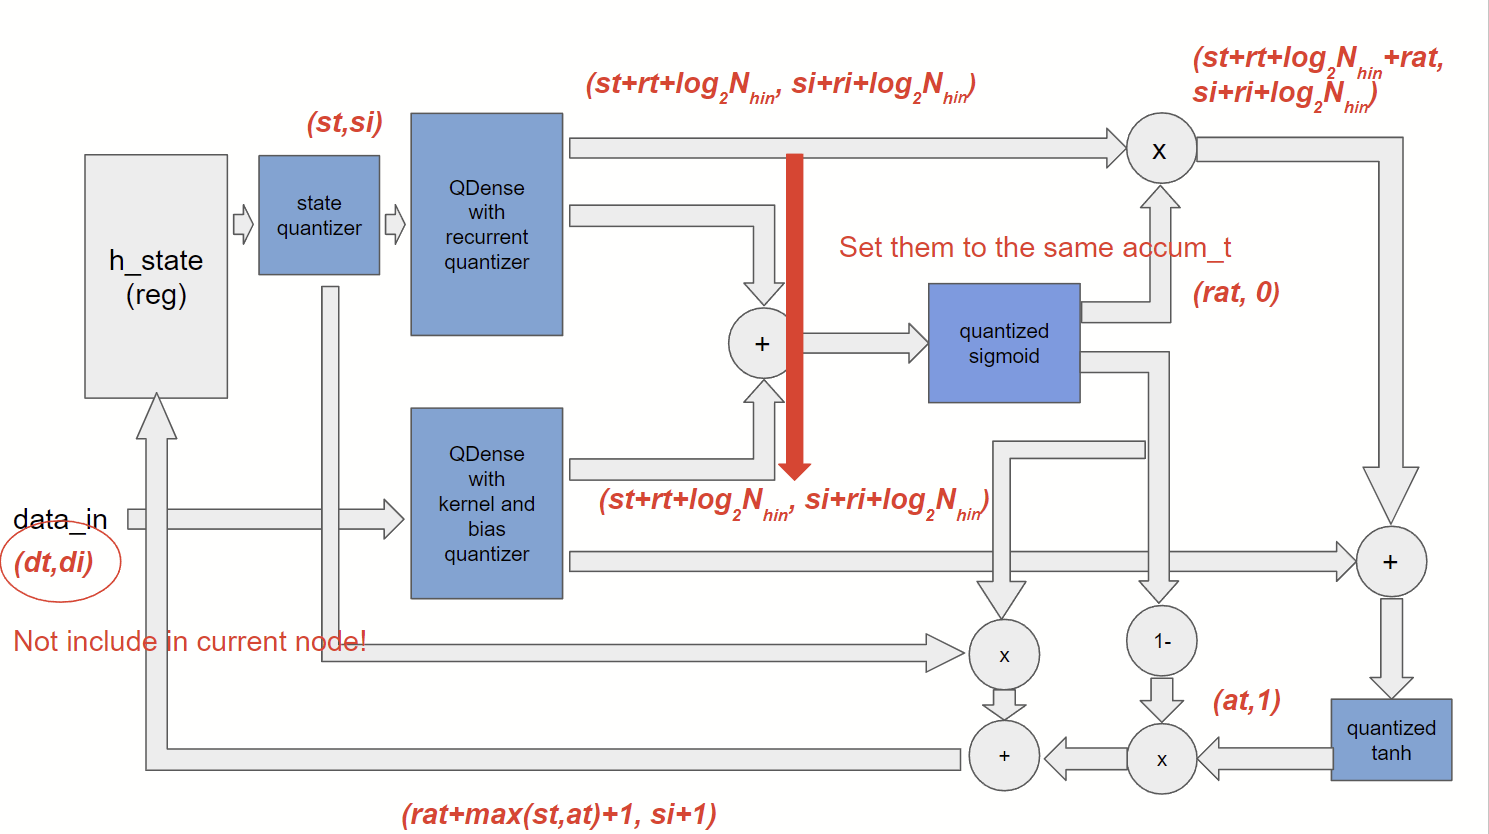

## the ACCUM bits in QGRU is based on the state quantizer, so the previous act_quan precision should be less than it
## here set the state quantizer same as the act_quan

# input for decoder GRU
# Assuming inputs are zero and everything comes from the GRU

In [31]:
decoder_dim = 64

In [32]:
def get_decoder_input(decoder_dim=64):
    inputs2decoder_train = tf.stack([tf.zeros_like(x_train)[:, :, -1]
                for i in range(decoder_dim)], axis=-1)
    inputs2decoder_val = tf.stack([tf.zeros_like(x_val)[:, :, -1]
                for i in range(decoder_dim)], axis=-1)
    inputs2decoder_train = np.array(inputs2decoder_train)
    inputs2decoder_val = np.array(inputs2decoder_val)
    print("inputs2decoder_train shape: ", inputs2decoder_train.shape)
    print("inputs2decoder_val shape: ", inputs2decoder_val.shape)
    return inputs2decoder_train, inputs2decoder_val

# Build models

## BenchMark fp-model

In [34]:
#from tensorflow.keras.models import load_model

In [38]:
#fmodel = load_model("fpmodel_xianhan.h5")

2023-07-12 15:16:29.215908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-12 15:16:29.217130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-12 15:16:29.218600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [39]:
#fmodel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 73, 70)]     0           []                               
                                                                                                  
 initial_dropout (Dropout)      (None, 73, 70)       0           ['input_1[0][0]']                
                                                                                                  
 Encoder_BidirectionalGRU (Bidi  [(None, 128),       52224       ['initial_dropout[0][0]']        
 rectional)                      (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                              

In [40]:
inputs2decoder_train, inputs2decoder_val = get_decoder_input(decoder_dim=64)

inputs2decoder_train shape:  (136, 73, 64)
inputs2decoder_val shape:  (17, 73, 64)


In [41]:
#pred_val_z, pred_val_logf = fmodel.predict([x_val, inputs2decoder_val])

/home/docker/anaconda3/envs/NNGEN/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2023-07-12 15:16:33.858998: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /usr/local/nvidia/lib64/libcublas.so.11: undefined symbol: cublasGetSmCountTarget


1/1 [==============================] - 1s 918ms/step


In [42]:
def evaluate_NPLL(targets, pred_logrates):
    targets = tf.cast(targets, dtype=tf.float32)
    logrates = tf.cast(tf.math.log(0.01) + pred_logrates, tf.float32)  # Timestep
    npll = tf.nn.log_poisson_loss(targets=targets,log_input=logrates, compute_full_loss=True)
    results = tf.reduce_sum(npll, axis=[1, 2]) # sum up each batch seperately
    results = tf.reduce_mean(results) # batch mean

    print(results) # negative possion loglikelihood

In [43]:
#evaluate_NPLL(targets=x_val, pred_logrates=pred_val_logf)

tf.Tensor(1768.8014, shape=(), dtype=float32)


In [44]:
#del fmodel

# loss: poisson_loglike_loss

In [45]:
from tensorflow.keras import backend as K

In [46]:
BATCH_SIZE=16

In [47]:
timestep = 0.01

def poisson_loglike_loss(y_true, y_pred):    
    # POISSON LOG-LIKELIHOOD
    # clip the y_pred first
    y_pred = tf.clip_by_value(y_pred, 
                                     clip_value_min=-threshold_poisson_log_firing_rate,
                                     clip_value_max=threshold_poisson_log_firing_rate
                             )
    targets = tf.cast(y_true, dtype=tf.float32)
    logrates = tf.cast(tf.math.log(timestep) + y_pred, tf.float32)  # Timestep
    npll = tf.nn.log_poisson_loss(
        targets=targets,
        log_input=logrates, compute_full_loss=True
    )
    #print(npll.shape)
    loss = tf.reduce_sum(npll, axis=[1, 2]) # sum up each batch seperately
    loss = tf.reduce_mean(loss) # batch mean
    #loss = tf.reduce_sum()
    return loss

## Build a fp model and train
## compare with the benchmark model

In [48]:
import tensorflow.keras.layers as tfl
from tensorflow.keras import Model

In [49]:
def create_fpmodel(input_shape = (73,70),
                    encoder_dim=64,  
                   decoder_dim = decoder_dim,
                   factors = 4,
                   drop=dropout
                  ):
    
    # input layer
    inputLayer =  tfl.Input(shape=input_shape)        
    x = tfl.Dropout(drop, name = 'initial_dropout')(inputLayer)
    
    # encoder
    forward_layer = tfl.GRU(
            encoder_dim, 
            time_major=False,
            name="EncoderGRUForward",
            return_state=True,
            kernel_regularizer=layers_settings['encoder']['kernel_regularizer'],
            kernel_initializer=layers_settings['encoder']['kernel_initializer'],
            )
    
    backward_layer = tfl.GRU(
            encoder_dim, 
            time_major=False,
            name="EncoderGRUBackward",
            return_state=True, 
            go_backwards=True,
            kernel_regularizer=layers_settings['encoder']['kernel_regularizer'],
            kernel_initializer=layers_settings['encoder']['kernel_initializer'],
             )
                
    x = tfl.Bidirectional(
        forward_layer, 
        backward_layer=backward_layer,
        merge_mode='concat', 
        name = 'Encoder_BidirectionalGRU'
        )(x)[0]  
    
    x = tfl.Dropout(drop, name = 'postencoder_dropout')(x)
    
    # latent space, no mean and var 
    # since the latent vector will become the initial state of the decoder GRU, 
    # decoder_dim = latent dimension
    x = tfl.Dense(decoder_dim, 
               kernel_regularizer=layers_settings['dense_mean']['kernel_regularizer'],
               kernel_initializer=layers_settings['dense_mean']['kernel_initializer'],
               name='dense_latent'
              )(x)
    
    # decoder
    input_decoder_shape = (input_shape[0], decoder_dim) #( 73 timesteps, 64 decoder_dim)
    input_decoder = tfl.Input(shape=input_decoder_shape)
        
    x = tfl.GRU(
                decoder_dim,                
                return_sequences=True,
                time_major=False,
                name='DecoderGRU'
                )(input_decoder, initial_state = x)
    x = tfl.Dropout(drop, name = 'postdecoder_dropout')(x)
    
    # DIMENSIONALITY REDUCTION
    z = tfl.Dense(
            factors, 
            use_bias=False, 
            kernel_regularizer=layers_settings['dense']['kernel_regularizer'],
            kernel_initializer=layers_settings['dense']['kernel_initializer'],
            name="dense"
            )(x)
    
    # NEURAL
    neural_dim = input_shape[-1] #70
    
    z = tfl.Dense(
            neural_dim, 
            use_bias=True, 
            kernel_regularizer=layers_settings['nerual_dense']['kernel_regularizer'],
            kernel_initializer=layers_settings['nerual_dense']['kernel_initializer'],
            name='nerual_dense')(z)
    
    
    model = Model(inputs = [inputLayer,input_decoder], outputs =z)
    
    return model
    

# train the fp model

In [161]:
fpmodel = create_fpmodel()

In [162]:
fpmodel.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 73, 70)]     0           []                               
                                                                                                  
 initial_dropout (Dropout)      (None, 73, 70)       0           ['input_24[0][0]']               
                                                                                                  
 Encoder_BidirectionalGRU (Bidi  [(None, 128),       52224       ['initial_dropout[0][0]']        
 rectional)                      (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                           

# train
## callbacks

In [163]:
csv_logger = tf.keras.callbacks.CSVLogger("fp_log.csv", separator=",", append=False)
model_check = tf.keras.callbacks.ModelCheckpoint(
    "lfadfp.h5",
    monitor = "val_loss",
    save_best_only = True,
    save_weights_only= False
)
early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=100,
    verbose=1,
    mode="min",
    baseline=None,
    restore_best_weights=True,
)

lfadfp_callbacks=[csv_logger, model_check, early]

In [164]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-2,
    beta_1=0.9, 
    beta_2=0.999,
    epsilon=1e-08)


In [165]:
fpmodel.compile(
    loss = poisson_loglike_loss,
    optimizer = optimizer
)

In [166]:
fpmodel_history=fpmodel.fit([x_train, inputs2decoder_train], x_train, batch_size = BATCH_SIZE, epochs=10000, 
          callbacks = lfadfp_callbacks,
          validation_data=([x_val, inputs2decoder_val], x_val)
         )

Epoch 1/10000
9/9 [==============================] - 0s 52ms/step - loss: 3000.9448 - val_loss: 2744.1719
Epoch 2/10000
9/9 [==============================] - 0s 44ms/step - loss: 2621.7803 - val_loss: 2399.7068
Epoch 3/10000
9/9 [==============================] - 0s 45ms/step - loss: 2312.3101 - val_loss: 2143.6670
Epoch 4/10000
9/9 [==============================] - 0s 45ms/step - loss: 2092.8936 - val_loss: 1976.2964
Epoch 5/10000
9/9 [==============================] - 0s 40ms/step - loss: 1955.1898 - val_loss: 1880.2726
Epoch 6/10000
9/9 [==============================] - 0s 45ms/step - loss: 1882.1598 - val_loss: 1838.7418
Epoch 7/10000
9/9 [==============================] - 0s 45ms/step - loss: 1850.4299 - val_loss: 1820.4463
Epoch 8/10000
9/9 [==============================] - 0s 42ms/step - loss: 1834.3115 - val_loss: 1816.4210
Epoch 9/10000
9/9 [==============================] - 0s 46ms/step - loss: 1828.5623 - val_loss: 1815.9033
Epoch 10/10000
9/9 [==========================

9/9 [==============================] - 0s 39ms/step - loss: 1763.9365 - val_loss: 1768.8004
Epoch 154/10000
9/9 [==============================] - 0s 42ms/step - loss: 1763.3267 - val_loss: 1767.0087
Epoch 155/10000
9/9 [==============================] - 0s 42ms/step - loss: 1763.8214 - val_loss: 1770.6802
Epoch 156/10000
9/9 [==============================] - 0s 36ms/step - loss: 1763.2057 - val_loss: 1767.9644
Epoch 157/10000
9/9 [==============================] - 0s 42ms/step - loss: 1763.4255 - val_loss: 1768.3384
Epoch 158/10000
9/9 [==============================] - 0s 42ms/step - loss: 1762.9902 - val_loss: 1769.6744
Epoch 159/10000
9/9 [==============================] - 0s 37ms/step - loss: 1763.2842 - val_loss: 1766.9756
Epoch 160/10000
9/9 [==============================] - 0s 35ms/step - loss: 1763.3506 - val_loss: 1767.2852
Epoch 161/10000
9/9 [==============================] - 0s 46ms/step - loss: 1762.1671 - val_loss: 1765.5439
Epoch 162/10000
9/9 [=======================

9/9 [==============================] - 0s 34ms/step - loss: 1758.2404 - val_loss: 1765.7655
Epoch 230/10000
9/9 [==============================] - 0s 42ms/step - loss: 1758.1150 - val_loss: 1766.5367
Epoch 231/10000
9/9 [==============================] - 0s 46ms/step - loss: 1758.6605 - val_loss: 1764.9188
Epoch 232/10000
9/9 [==============================] - 0s 41ms/step - loss: 1757.9072 - val_loss: 1766.4636
Epoch 233/10000
9/9 [==============================] - 0s 38ms/step - loss: 1759.4482 - val_loss: 1768.0342
Epoch 234/10000
9/9 [==============================] - 0s 42ms/step - loss: 1759.3726 - val_loss: 1765.2112
Epoch 235/10000
9/9 [==============================] - 0s 42ms/step - loss: 1759.3547 - val_loss: 1768.9258
Epoch 236/10000
9/9 [==============================] - 0s 34ms/step - loss: 1758.5453 - val_loss: 1766.1871
Epoch 237/10000
9/9 [==============================] - 0s 35ms/step - loss: 1758.8826 - val_loss: 1765.5459
Epoch 238/10000
9/9 [=======================

9/9 [==============================] - 0s 37ms/step - loss: 1754.5538 - val_loss: 1767.5731
Epoch 306/10000
9/9 [==============================] - 0s 36ms/step - loss: 1755.9388 - val_loss: 1765.6006
Epoch 307/10000
9/9 [==============================] - 0s 39ms/step - loss: 1754.8297 - val_loss: 1766.4521
Epoch 308/10000
9/9 [==============================] - 0s 46ms/step - loss: 1754.1509 - val_loss: 1764.5872
Epoch 309/10000
9/9 [==============================] - 0s 39ms/step - loss: 1754.1182 - val_loss: 1766.2275
Epoch 310/10000
9/9 [==============================] - 0s 42ms/step - loss: 1754.1326 - val_loss: 1766.8776
Epoch 311/10000
9/9 [==============================] - 0s 35ms/step - loss: 1754.0078 - val_loss: 1765.6829
Epoch 312/10000
9/9 [==============================] - 0s 42ms/step - loss: 1754.3209 - val_loss: 1766.5813
Epoch 313/10000
9/9 [==============================] - 0s 42ms/step - loss: 1754.5175 - val_loss: 1767.0725
Epoch 314/10000
9/9 [=======================

9/9 [==============================] - 0s 38ms/step - loss: 1750.9148 - val_loss: 1763.8661
Epoch 382/10000
9/9 [==============================] - 0s 42ms/step - loss: 1750.7087 - val_loss: 1763.8689
Epoch 383/10000
9/9 [==============================] - 0s 42ms/step - loss: 1750.2369 - val_loss: 1764.0972
Epoch 384/10000
9/9 [==============================] - 0s 43ms/step - loss: 1749.7045 - val_loss: 1766.1509
Epoch 385/10000
9/9 [==============================] - 0s 39ms/step - loss: 1750.6299 - val_loss: 1763.4497
Epoch 386/10000
9/9 [==============================] - 0s 45ms/step - loss: 1749.3813 - val_loss: 1764.4247
Epoch 387/10000
9/9 [==============================] - 0s 41ms/step - loss: 1749.5566 - val_loss: 1764.7150
Epoch 388/10000
9/9 [==============================] - 0s 51ms/step - loss: 1749.5013 - val_loss: 1763.8805
Epoch 389/10000
9/9 [==============================] - 0s 45ms/step - loss: 1749.6731 - val_loss: 1764.4420
Epoch 390/10000
9/9 [=======================

9/9 [==============================] - 0s 34ms/step - loss: 1748.5031 - val_loss: 1761.8490
Epoch 458/10000
9/9 [==============================] - 0s 42ms/step - loss: 1748.4325 - val_loss: 1765.1379
Epoch 459/10000
9/9 [==============================] - 0s 34ms/step - loss: 1748.1025 - val_loss: 1761.4463
Epoch 460/10000
9/9 [==============================] - 0s 42ms/step - loss: 1747.9000 - val_loss: 1761.7778
Epoch 461/10000
9/9 [==============================] - 0s 42ms/step - loss: 1747.1572 - val_loss: 1763.1738
Epoch 462/10000
9/9 [==============================] - 0s 41ms/step - loss: 1747.0627 - val_loss: 1763.0612
Epoch 463/10000
9/9 [==============================] - 0s 47ms/step - loss: 1747.1991 - val_loss: 1759.7728
Epoch 464/10000
9/9 [==============================] - 0s 43ms/step - loss: 1746.8662 - val_loss: 1761.3718
Epoch 465/10000
9/9 [==============================] - 0s 43ms/step - loss: 1746.9904 - val_loss: 1761.9332
Epoch 466/10000
9/9 [=======================

9/9 [==============================] - 0s 35ms/step - loss: 1745.2522 - val_loss: 1764.9774
Epoch 534/10000
9/9 [==============================] - 0s 37ms/step - loss: 1745.8623 - val_loss: 1764.8984
Epoch 535/10000
9/9 [==============================] - 0s 38ms/step - loss: 1744.6475 - val_loss: 1764.1250
Epoch 536/10000
9/9 [==============================] - 0s 42ms/step - loss: 1744.4287 - val_loss: 1764.6903
Epoch 537/10000
9/9 [==============================] - 0s 42ms/step - loss: 1743.5334 - val_loss: 1764.3693
Epoch 538/10000
9/9 [==============================] - 0s 36ms/step - loss: 1743.4086 - val_loss: 1763.5886
Epoch 539/10000
9/9 [==============================] - 0s 35ms/step - loss: 1743.8644 - val_loss: 1764.1444
Epoch 540/10000
9/9 [==============================] - 0s 37ms/step - loss: 1744.3698 - val_loss: 1762.9016
Epoch 541/10000
9/9 [==============================] - 0s 36ms/step - loss: 1743.9797 - val_loss: 1762.9458
Epoch 542/10000
9/9 [=======================

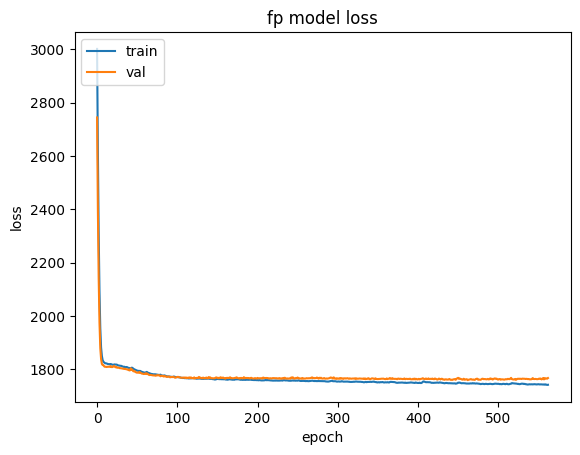

In [167]:
plt.plot(fpmodel_history.history['loss'])
plt.plot(fpmodel_history.history['val_loss'])
plt.title('fp model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("fp model loss")
plt.show()

In [169]:
pred_val_logf = fpmodel.predict([x_val, inputs2decoder_val])

In [170]:
evaluate_NPLL(targets=x_val, pred_logrates=pred_val_logf)

tf.Tensor(1759.7743, shape=(), dtype=float32)


# test increase latent dimension(same as decoder_dim)

In [139]:
decoder_dim = 1024

In [140]:
inputs2decoder_latent1024_train, inputs2decoder_latent1024_val = get_decoder_input(decoder_dim=decoder_dim)

inputs2decoder_train shape:  (136, 73, 1024)
inputs2decoder_val shape:  (17, 73, 1024)


In [141]:
fp_latent1024_model = create_fpmodel(decoder_dim = decoder_dim)

In [142]:
fp_latent1024_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 73, 70)]     0           []                               
                                                                                                  
 initial_dropout (Dropout)      (None, 73, 70)       0           ['input_20[0][0]']               
                                                                                                  
 Encoder_BidirectionalGRU (Bidi  [(None, 128),       52224       ['initial_dropout[0][0]']        
 rectional)                      (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                            

# train
## callbacks

In [143]:
csv_logger = tf.keras.callbacks.CSVLogger("fp_log.csv", separator=",", append=False)
model_check = tf.keras.callbacks.ModelCheckpoint(
    "lfadfp.h5",
    monitor = "val_loss",
    save_best_only = True,
    save_weights_only= False
)
early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=100,
    verbose=1,
    mode="min",
    baseline=None,
    restore_best_weights=True,
)

lfadfp_latent1024_callbacks=[csv_logger, model_check, early]

In [144]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-2,
    beta_1=0.9, 
    beta_2=0.999,
    epsilon=1e-08)


In [145]:
fp_latent1024_model.compile(
    loss = poisson_loglike_loss,
    optimizer = optimizer
)

In [146]:
fp_latent1024_model_history=fp_latent1024_model.fit([x_train, inputs2decoder_latent1024_train], x_train, batch_size = BATCH_SIZE, epochs=10000, 
          callbacks = lfadfp_latent1024_callbacks,
          validation_data=([x_val, inputs2decoder_latent1024_val], x_val)
         )

Epoch 1/10000
9/9 [==============================] - 1s 70ms/step - loss: 129088.5312 - val_loss: 2420215.7500
Epoch 2/10000
9/9 [==============================] - 0s 55ms/step - loss: 330723.5938 - val_loss: 31206.8008
Epoch 3/10000
9/9 [==============================] - 1s 58ms/step - loss: 94528.8359 - val_loss: 10459.7051
Epoch 4/10000
9/9 [==============================] - 1s 58ms/step - loss: 8259.1641 - val_loss: 4270.5562
Epoch 5/10000
9/9 [==============================] - 0s 54ms/step - loss: 4032.0286 - val_loss: 3412.8433
Epoch 6/10000
9/9 [==============================] - 0s 55ms/step - loss: 3379.5310 - val_loss: 3161.7307
Epoch 7/10000
9/9 [==============================] - 0s 53ms/step - loss: 3154.5249 - val_loss: 3022.8486
Epoch 8/10000
9/9 [==============================] - 0s 57ms/step - loss: 3024.3691 - val_loss: 2926.9797
Epoch 9/10000
9/9 [==============================] - 1s 60ms/step - loss: 2941.1965 - val_loss: 2852.9690
Epoch 10/10000
9/9 [================

9/9 [==============================] - 0s 56ms/step - loss: 1979.5750 - val_loss: 1973.6349
Epoch 154/10000
9/9 [==============================] - 0s 56ms/step - loss: 1978.6310 - val_loss: 1971.4888
Epoch 155/10000
9/9 [==============================] - 0s 52ms/step - loss: 1978.0721 - val_loss: 1969.7180
Epoch 156/10000
9/9 [==============================] - 0s 56ms/step - loss: 1976.4807 - val_loss: 1968.2651
Epoch 157/10000
9/9 [==============================] - 0s 56ms/step - loss: 1975.1903 - val_loss: 1966.7880
Epoch 158/10000
9/9 [==============================] - 0s 52ms/step - loss: 1973.9401 - val_loss: 1964.6370
Epoch 159/10000
9/9 [==============================] - 0s 53ms/step - loss: 1972.1104 - val_loss: 1963.0125
Epoch 160/10000
9/9 [==============================] - 0s 55ms/step - loss: 1970.1091 - val_loss: 1961.3654
Epoch 161/10000
9/9 [==============================] - 0s 54ms/step - loss: 1969.0497 - val_loss: 1959.7289
Epoch 162/10000
9/9 [=======================

9/9 [==============================] - 0s 45ms/step - loss: 1899.1360 - val_loss: 1883.1335
Epoch 230/10000
9/9 [==============================] - 1s 58ms/step - loss: 1897.4507 - val_loss: 1882.2288
Epoch 231/10000
9/9 [==============================] - 1s 68ms/step - loss: 1898.0472 - val_loss: 1881.8315
Epoch 232/10000
9/9 [==============================] - 0s 54ms/step - loss: 1897.0448 - val_loss: 1881.2410
Epoch 233/10000
9/9 [==============================] - 1s 63ms/step - loss: 1896.5880 - val_loss: 1880.0323
Epoch 234/10000
9/9 [==============================] - 0s 53ms/step - loss: 1895.4209 - val_loss: 1880.0321
Epoch 235/10000
9/9 [==============================] - 0s 55ms/step - loss: 1896.0581 - val_loss: 1879.2900
Epoch 236/10000
9/9 [==============================] - 0s 54ms/step - loss: 1895.1205 - val_loss: 1878.8378
Epoch 237/10000
9/9 [==============================] - 0s 56ms/step - loss: 1894.8920 - val_loss: 1878.3019
Epoch 238/10000
9/9 [=======================

9/9 [==============================] - 0s 56ms/step - loss: 1869.1506 - val_loss: 1852.9138
Epoch 306/10000
9/9 [==============================] - 0s 41ms/step - loss: 1869.4457 - val_loss: 1853.3567
Epoch 307/10000
9/9 [==============================] - 0s 43ms/step - loss: 1868.6643 - val_loss: 1852.9756
Epoch 308/10000
9/9 [==============================] - 1s 64ms/step - loss: 1869.6223 - val_loss: 1852.8765
Epoch 309/10000
9/9 [==============================] - 0s 58ms/step - loss: 1869.2622 - val_loss: 1852.6897
Epoch 310/10000
9/9 [==============================] - 1s 60ms/step - loss: 1867.5677 - val_loss: 1852.4418
Epoch 311/10000
9/9 [==============================] - 0s 44ms/step - loss: 1868.2738 - val_loss: 1852.5479
Epoch 312/10000
9/9 [==============================] - 0s 54ms/step - loss: 1868.6725 - val_loss: 1852.2699
Epoch 313/10000
9/9 [==============================] - 0s 57ms/step - loss: 1867.7408 - val_loss: 1852.1119
Epoch 314/10000
9/9 [=======================

9/9 [==============================] - 1s 62ms/step - loss: 1854.3467 - val_loss: 1842.1946
Epoch 382/10000
9/9 [==============================] - 0s 56ms/step - loss: 1855.8939 - val_loss: 1841.7401
Epoch 383/10000
9/9 [==============================] - 0s 44ms/step - loss: 1855.8693 - val_loss: 1841.9301
Epoch 384/10000
9/9 [==============================] - 1s 57ms/step - loss: 1855.7411 - val_loss: 1841.2783
Epoch 385/10000
9/9 [==============================] - 0s 44ms/step - loss: 1855.9280 - val_loss: 1841.3070
Epoch 386/10000
9/9 [==============================] - 0s 43ms/step - loss: 1854.8525 - val_loss: 1841.6376
Epoch 387/10000
9/9 [==============================] - 1s 63ms/step - loss: 1854.6281 - val_loss: 1841.1315
Epoch 388/10000
9/9 [==============================] - 0s 42ms/step - loss: 1853.4904 - val_loss: 1841.5146
Epoch 389/10000
9/9 [==============================] - 0s 58ms/step - loss: 1854.0464 - val_loss: 1840.8997
Epoch 390/10000
9/9 [=======================

9/9 [==============================] - 1s 61ms/step - loss: 1844.7607 - val_loss: 1832.4596
Epoch 458/10000
9/9 [==============================] - 0s 42ms/step - loss: 1844.2998 - val_loss: 1833.2883
Epoch 459/10000
9/9 [==============================] - 0s 45ms/step - loss: 1844.7649 - val_loss: 1832.9248
Epoch 460/10000
9/9 [==============================] - 0s 48ms/step - loss: 1843.5238 - val_loss: 1833.3596
Epoch 461/10000
9/9 [==============================] - 0s 40ms/step - loss: 1842.5322 - val_loss: 1833.2395
Epoch 462/10000
9/9 [==============================] - 0s 43ms/step - loss: 1843.4760 - val_loss: 1832.9514
Epoch 463/10000
9/9 [==============================] - 0s 42ms/step - loss: 1842.6443 - val_loss: 1833.4935
Epoch 464/10000
9/9 [==============================] - 0s 57ms/step - loss: 1843.3488 - val_loss: 1832.4354
Epoch 465/10000
9/9 [==============================] - 0s 41ms/step - loss: 1843.0399 - val_loss: 1833.0062
Epoch 466/10000
9/9 [=======================

9/9 [==============================] - 0s 41ms/step - loss: 1835.1879 - val_loss: 1827.1018
Epoch 534/10000
9/9 [==============================] - 0s 42ms/step - loss: 1835.8871 - val_loss: 1827.4460
Epoch 535/10000
9/9 [==============================] - 0s 57ms/step - loss: 1835.9769 - val_loss: 1826.6669
Epoch 536/10000
9/9 [==============================] - 0s 56ms/step - loss: 1835.3320 - val_loss: 1826.1852
Epoch 537/10000
9/9 [==============================] - 0s 50ms/step - loss: 1834.9059 - val_loss: 1827.1639
Epoch 538/10000
9/9 [==============================] - 0s 43ms/step - loss: 1834.8744 - val_loss: 1826.3937
Epoch 539/10000
9/9 [==============================] - 0s 54ms/step - loss: 1836.5233 - val_loss: 1826.1683
Epoch 540/10000
9/9 [==============================] - 0s 41ms/step - loss: 1834.9353 - val_loss: 1826.6465
Epoch 541/10000
9/9 [==============================] - 0s 43ms/step - loss: 1835.2333 - val_loss: 1826.3103
Epoch 542/10000
9/9 [=======================

9/9 [==============================] - 0s 43ms/step - loss: 1831.1801 - val_loss: 1823.6354
Epoch 610/10000
9/9 [==============================] - 0s 43ms/step - loss: 1830.7913 - val_loss: 1823.2573
Epoch 611/10000
9/9 [==============================] - 0s 43ms/step - loss: 1830.3423 - val_loss: 1823.9052
Epoch 612/10000
9/9 [==============================] - 0s 57ms/step - loss: 1829.9783 - val_loss: 1822.8789
Epoch 613/10000
9/9 [==============================] - 0s 41ms/step - loss: 1830.8700 - val_loss: 1823.0560
Epoch 614/10000
9/9 [==============================] - 0s 43ms/step - loss: 1830.6498 - val_loss: 1823.3486
Epoch 615/10000
9/9 [==============================] - 0s 44ms/step - loss: 1829.8531 - val_loss: 1823.0303
Epoch 616/10000
9/9 [==============================] - 1s 66ms/step - loss: 1830.1062 - val_loss: 1822.3142
Epoch 617/10000
9/9 [==============================] - 0s 47ms/step - loss: 1829.8690 - val_loss: 1823.2466
Epoch 618/10000
9/9 [=======================

9/9 [==============================] - 0s 57ms/step - loss: 1825.7207 - val_loss: 1819.2292
Epoch 686/10000
9/9 [==============================] - 0s 42ms/step - loss: 1825.7484 - val_loss: 1819.3643
Epoch 687/10000
9/9 [==============================] - 0s 42ms/step - loss: 1825.6002 - val_loss: 1820.0854
Epoch 688/10000
9/9 [==============================] - 0s 39ms/step - loss: 1825.5331 - val_loss: 1820.3303
Epoch 689/10000
9/9 [==============================] - 0s 39ms/step - loss: 1825.5494 - val_loss: 1819.6608
Epoch 690/10000
9/9 [==============================] - 0s 39ms/step - loss: 1826.2686 - val_loss: 1819.8103
Epoch 691/10000
9/9 [==============================] - 0s 54ms/step - loss: 1826.0276 - val_loss: 1818.9366
Epoch 692/10000
9/9 [==============================] - 0s 41ms/step - loss: 1825.4542 - val_loss: 1820.1500
Epoch 693/10000
9/9 [==============================] - 0s 42ms/step - loss: 1826.7611 - val_loss: 1819.5195
Epoch 694/10000
9/9 [=======================

9/9 [==============================] - 0s 39ms/step - loss: 1821.2815 - val_loss: 1816.2806
Epoch 762/10000
9/9 [==============================] - 1s 61ms/step - loss: 1821.7336 - val_loss: 1816.0975
Epoch 763/10000
9/9 [==============================] - 0s 40ms/step - loss: 1820.7063 - val_loss: 1816.1506
Epoch 764/10000
9/9 [==============================] - 0s 53ms/step - loss: 1821.0751 - val_loss: 1815.9810
Epoch 765/10000
9/9 [==============================] - 0s 42ms/step - loss: 1820.8770 - val_loss: 1816.1537
Epoch 766/10000
9/9 [==============================] - 0s 53ms/step - loss: 1821.0165 - val_loss: 1815.8879
Epoch 767/10000
9/9 [==============================] - 0s 39ms/step - loss: 1821.1096 - val_loss: 1815.9187
Epoch 768/10000
9/9 [==============================] - 0s 56ms/step - loss: 1821.5176 - val_loss: 1815.8258
Epoch 769/10000
9/9 [==============================] - 0s 57ms/step - loss: 1821.4824 - val_loss: 1815.2588
Epoch 770/10000
9/9 [=======================

9/9 [==============================] - 0s 56ms/step - loss: 1816.5023 - val_loss: 1812.0504
Epoch 838/10000
9/9 [==============================] - 0s 42ms/step - loss: 1817.0242 - val_loss: 1812.5798
Epoch 839/10000
9/9 [==============================] - 0s 40ms/step - loss: 1816.5516 - val_loss: 1812.4707
Epoch 840/10000
9/9 [==============================] - 0s 43ms/step - loss: 1815.6782 - val_loss: 1812.3096
Epoch 841/10000
9/9 [==============================] - 0s 40ms/step - loss: 1817.5299 - val_loss: 1814.0153
Epoch 842/10000
9/9 [==============================] - 0s 42ms/step - loss: 1816.6509 - val_loss: 1813.0068
Epoch 843/10000
9/9 [==============================] - 0s 40ms/step - loss: 1818.4807 - val_loss: 1812.2988
Epoch 844/10000
9/9 [==============================] - 0s 56ms/step - loss: 1816.3258 - val_loss: 1811.7698
Epoch 845/10000
9/9 [==============================] - 1s 59ms/step - loss: 1817.0184 - val_loss: 1811.5645
Epoch 846/10000
9/9 [=======================

9/9 [==============================] - 0s 39ms/step - loss: 1811.3799 - val_loss: 1803.7599
Epoch 914/10000
9/9 [==============================] - 0s 40ms/step - loss: 1809.1810 - val_loss: 1804.5027
Epoch 915/10000
9/9 [==============================] - 0s 40ms/step - loss: 1810.9282 - val_loss: 1803.4294
Epoch 916/10000
9/9 [==============================] - 0s 56ms/step - loss: 1810.0175 - val_loss: 1803.2241
Epoch 917/10000
9/9 [==============================] - 0s 54ms/step - loss: 1811.2526 - val_loss: 1803.2185
Epoch 918/10000
9/9 [==============================] - 0s 43ms/step - loss: 1811.2731 - val_loss: 1804.0420
Epoch 919/10000
9/9 [==============================] - 0s 56ms/step - loss: 1808.8835 - val_loss: 1802.1008
Epoch 920/10000
9/9 [==============================] - 0s 40ms/step - loss: 1811.2061 - val_loss: 1804.0742
Epoch 921/10000
9/9 [==============================] - 0s 39ms/step - loss: 1809.4410 - val_loss: 1802.6721
Epoch 922/10000
9/9 [=======================

9/9 [==============================] - 0s 43ms/step - loss: 1810.6530 - val_loss: 1814.5144
Epoch 990/10000
9/9 [==============================] - 0s 46ms/step - loss: 1809.3641 - val_loss: 1810.7021
Epoch 991/10000
9/9 [==============================] - 0s 42ms/step - loss: 1807.6147 - val_loss: 1806.8469
Epoch 992/10000
9/9 [==============================] - 0s 41ms/step - loss: 1809.1626 - val_loss: 1806.1575
Epoch 993/10000
9/9 [==============================] - 0s 41ms/step - loss: 1808.4753 - val_loss: 1805.3837
Epoch 994/10000
9/9 [==============================] - 0s 43ms/step - loss: 1807.6234 - val_loss: 1806.7457
Epoch 995/10000
9/9 [==============================] - 0s 43ms/step - loss: 1807.6357 - val_loss: 1804.6154
Epoch 996/10000
9/9 [==============================] - 0s 42ms/step - loss: 1808.2426 - val_loss: 1804.7815
Epoch 997/10000
9/9 [==============================] - 0s 42ms/step - loss: 1806.2614 - val_loss: 1805.2295
Epoch 998/10000
9/9 [=======================

9/9 [==============================] - 0s 43ms/step - loss: 1801.9031 - val_loss: 1800.6680
Epoch 1140/10000
9/9 [==============================] - 0s 42ms/step - loss: 1799.0054 - val_loss: 1798.6104
Epoch 1141/10000
9/9 [==============================] - 0s 43ms/step - loss: 1800.2979 - val_loss: 1798.1710
Epoch 1142/10000
9/9 [==============================] - 0s 40ms/step - loss: 1798.0813 - val_loss: 1798.7703
Epoch 1143/10000
9/9 [==============================] - 0s 44ms/step - loss: 1797.3566 - val_loss: 1797.5420
Epoch 1144/10000
9/9 [==============================] - 0s 43ms/step - loss: 1798.9677 - val_loss: 1797.1057
Epoch 1145/10000
9/9 [==============================] - 0s 43ms/step - loss: 1797.9031 - val_loss: 1800.8567
Epoch 1146/10000
9/9 [==============================] - 0s 46ms/step - loss: 1797.8721 - val_loss: 1796.0151
Epoch 1147/10000
9/9 [==============================] - 0s 46ms/step - loss: 1798.0375 - val_loss: 1800.6826
Epoch 1148/10000
9/9 [==============

9/9 [==============================] - 0s 39ms/step - loss: 1781.9648 - val_loss: 1789.2914
Epoch 1290/10000
9/9 [==============================] - 0s 43ms/step - loss: 1781.2039 - val_loss: 1784.1608
Epoch 1291/10000
9/9 [==============================] - 0s 43ms/step - loss: 1780.5221 - val_loss: 1784.2418
Epoch 1292/10000
9/9 [==============================] - 0s 43ms/step - loss: 1782.2089 - val_loss: 1785.1064
Epoch 1293/10000
9/9 [==============================] - 0s 42ms/step - loss: 1783.0017 - val_loss: 1786.7085
Epoch 1294/10000
9/9 [==============================] - 0s 43ms/step - loss: 1782.1050 - val_loss: 1786.6743
Epoch 1295/10000
9/9 [==============================] - 0s 43ms/step - loss: 1781.0483 - val_loss: 1786.5422
Epoch 1296/10000
9/9 [==============================] - 0s 40ms/step - loss: 1780.3937 - val_loss: 1784.8646
Epoch 1297/10000
9/9 [==============================] - 0s 47ms/step - loss: 1779.4062 - val_loss: 1784.6807
Epoch 1298/10000
9/9 [==============

9/9 [==============================] - 0s 40ms/step - loss: 1772.5170 - val_loss: 1779.3529
Epoch 1440/10000
9/9 [==============================] - 0s 43ms/step - loss: 1772.4669 - val_loss: 1785.5398
Epoch 1441/10000
9/9 [==============================] - 0s 43ms/step - loss: 1773.7545 - val_loss: 1782.5371
Epoch 1442/10000
9/9 [==============================] - 0s 40ms/step - loss: 1772.1235 - val_loss: 1781.5536
Epoch 1443/10000
9/9 [==============================] - 0s 44ms/step - loss: 1772.0693 - val_loss: 1778.5071
Epoch 1444/10000
9/9 [==============================] - 0s 44ms/step - loss: 1771.4896 - val_loss: 1780.0605
Epoch 1445/10000
9/9 [==============================] - 0s 49ms/step - loss: 1771.4281 - val_loss: 1779.6409
Epoch 1446/10000
9/9 [==============================] - 0s 42ms/step - loss: 1770.8734 - val_loss: 1785.0258
Epoch 1447/10000
9/9 [==============================] - 0s 43ms/step - loss: 1772.0986 - val_loss: 1783.9772
Epoch 1448/10000
9/9 [==============

9/9 [==============================] - 0s 40ms/step - loss: 1767.6473 - val_loss: 1779.7222
Epoch 1590/10000
9/9 [==============================] - 0s 43ms/step - loss: 1767.3707 - val_loss: 1777.7369
Epoch 1591/10000
9/9 [==============================] - 0s 41ms/step - loss: 1767.2172 - val_loss: 1775.8813
Epoch 1592/10000
9/9 [==============================] - 0s 41ms/step - loss: 1767.4927 - val_loss: 1776.2145
Epoch 1593/10000
9/9 [==============================] - 0s 38ms/step - loss: 1767.0630 - val_loss: 1777.6296
Epoch 1594/10000
9/9 [==============================] - 0s 42ms/step - loss: 1766.8759 - val_loss: 1776.5211
Epoch 1595/10000
9/9 [==============================] - 0s 42ms/step - loss: 1766.9399 - val_loss: 1778.1241
Epoch 1596/10000
9/9 [==============================] - 0s 44ms/step - loss: 1767.0260 - val_loss: 1778.7291
Epoch 1597/10000
9/9 [==============================] - 0s 43ms/step - loss: 1768.2670 - val_loss: 1784.3745
Epoch 1598/10000
9/9 [==============

9/9 [==============================] - 0s 40ms/step - loss: 1762.3174 - val_loss: 1775.6346
Epoch 1740/10000
9/9 [==============================] - 0s 43ms/step - loss: 1762.7415 - val_loss: 1774.5830
Epoch 1741/10000
9/9 [==============================] - 0s 42ms/step - loss: 1762.1322 - val_loss: 1776.7395
Epoch 1742/10000
9/9 [==============================] - 0s 42ms/step - loss: 1763.2526 - val_loss: 1775.6591
Epoch 1743/10000
9/9 [==============================] - 0s 40ms/step - loss: 1762.4899 - val_loss: 1773.7865
Epoch 1744/10000
9/9 [==============================] - 0s 40ms/step - loss: 1762.7263 - val_loss: 1776.2314
Epoch 1745/10000
9/9 [==============================] - 0s 45ms/step - loss: 1762.6289 - val_loss: 1775.3849
Epoch 1746/10000
9/9 [==============================] - 0s 44ms/step - loss: 1761.7842 - val_loss: 1775.7463
Epoch 1747/10000
9/9 [==============================] - 0s 42ms/step - loss: 1762.5378 - val_loss: 1773.8046
Epoch 1748/10000
9/9 [==============

# test increase encoder dimension

In [151]:
decoder_dim = 64

In [152]:
inputs2decoder_encoder1024_train, inputs2decoder_encoder1024_val = get_decoder_input(decoder_dim=decoder_dim)

inputs2decoder_train shape:  (136, 73, 64)
inputs2decoder_val shape:  (17, 73, 64)


In [153]:
fp_encoder1024_model = create_fpmodel(encoder_dim=1024, decoder_dim = decoder_dim)

In [154]:
fp_encoder1024_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 73, 70)]     0           []                               
                                                                                                  
 initial_dropout (Dropout)      (None, 73, 70)       0           ['input_22[0][0]']               
                                                                                                  
 Encoder_BidirectionalGRU (Bidi  [(None, 2048),      6733824     ['initial_dropout[0][0]']        
 rectional)                      (None, 1024),                                                    
                                 (None, 1024)]                                                    
                                                                                            

# train
## callbacks

In [155]:
csv_logger = tf.keras.callbacks.CSVLogger("fp_log.csv", separator=",", append=False)
model_check = tf.keras.callbacks.ModelCheckpoint(
    "lfadfp.h5",
    monitor = "val_loss",
    save_best_only = True,
    save_weights_only= False
)
early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=100,
    verbose=1,
    mode="min",
    baseline=None,
    restore_best_weights=True,
)

lfadfp_encoder1024_callbacks=[csv_logger, model_check, early]

In [156]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-2,
    beta_1=0.9, 
    beta_2=0.999,
    epsilon=1e-08)


In [157]:
fp_encoder1024_model.compile(
    loss = poisson_loglike_loss,
    optimizer = optimizer
)

In [160]:
fp_encoder1024_model_history=fp_encoder1024_model.fit([x_train, inputs2decoder_encoder1024_train], x_train, batch_size = BATCH_SIZE, epochs=10000, 
          callbacks = lfadfp_latent1024_callbacks,
          validation_data=([x_val, inputs2decoder_encoder1024_val], x_val)
         )

Epoch 1/10000
9/9 [==============================] - 1s 47ms/step - loss: 18580084736.0000 - val_loss: 30069.4863
Epoch 2/10000
9/9 [==============================] - 0s 41ms/step - loss: 14850472960.0000 - val_loss: 14066029.0000
Epoch 3/10000
9/9 [==============================] - 0s 42ms/step - loss: 135977975808.0000 - val_loss: 12542960.0000
Epoch 4/10000
9/9 [==============================] - 0s 41ms/step - loss: 1493950398464.0000 - val_loss: 1632980.5000
Epoch 5/10000
9/9 [==============================] - 0s 42ms/step - loss: 270346338304.0000 - val_loss: 1323359.6250
Epoch 6/10000
9/9 [==============================] - 0s 46ms/step - loss: 7534167552.0000 - val_loss: 472962.5938
Epoch 7/10000
9/9 [==============================] - 0s 42ms/step - loss: 2478222336.0000 - val_loss: 2655280.7500
Epoch 8/10000
9/9 [==============================] - 0s 43ms/step - loss: 1887852416.0000 - val_loss: 28736.5410
Epoch 9/10000
9/9 [==============================] - 0s 47ms/step - loss: 

Epoch 75/10000
9/9 [==============================] - 0s 42ms/step - loss: 1618072.0000 - val_loss: 4098.1709
Epoch 76/10000
9/9 [==============================] - 0s 43ms/step - loss: 3840727.0000 - val_loss: 4095.2468
Epoch 77/10000
9/9 [==============================] - 0s 42ms/step - loss: 4824847.0000 - val_loss: 4089.2109
Epoch 78/10000
9/9 [==============================] - 0s 45ms/step - loss: 426782.6250 - val_loss: 4083.1499
Epoch 79/10000
9/9 [==============================] - 0s 43ms/step - loss: 3285831.0000 - val_loss: 4079.6807
Epoch 80/10000
9/9 [==============================] - 0s 45ms/step - loss: 1235307.8750 - val_loss: 4073.5713
Epoch 81/10000
9/9 [==============================] - 0s 42ms/step - loss: 62056.4336 - val_loss: 4071.5801
Epoch 82/10000
9/9 [==============================] - 0s 45ms/step - loss: 203778.4531 - val_loss: 4069.6230
Epoch 83/10000
9/9 [==============================] - 0s 43ms/step - loss: 3817082.0000 - val_loss: 4062.1182
Epoch 84/10000

Epoch 224/10000
9/9 [==============================] - 0s 44ms/step - loss: 60264.7891 - val_loss: 3492.2783
Epoch 225/10000
9/9 [==============================] - 0s 43ms/step - loss: 32048.0469 - val_loss: 3491.2332
Epoch 226/10000
9/9 [==============================] - 0s 40ms/step - loss: 15188.0088 - val_loss: 3490.0557
Epoch 227/10000
9/9 [==============================] - 0s 46ms/step - loss: 1274286.1250 - val_loss: 3488.7676
Epoch 228/10000
9/9 [==============================] - 0s 44ms/step - loss: 367032.5312 - val_loss: 3486.6240
Epoch 229/10000
9/9 [==============================] - 0s 40ms/step - loss: 65500.8984 - val_loss: 3485.2598
Epoch 230/10000
9/9 [==============================] - 0s 44ms/step - loss: 82076.7812 - val_loss: 3481.9929
Epoch 231/10000
9/9 [==============================] - 0s 41ms/step - loss: 319723.6250 - val_loss: 3480.2676
Epoch 232/10000
9/9 [==============================] - 0s 46ms/step - loss: 113248.6406 - val_loss: 3479.1018
Epoch 233/1000

Epoch 299/10000
9/9 [==============================] - 0s 44ms/step - loss: 107105.6328 - val_loss: 3378.5320
Epoch 300/10000
9/9 [==============================] - 0s 43ms/step - loss: 398720.8750 - val_loss: 3377.3210
Epoch 301/10000
9/9 [==============================] - 0s 45ms/step - loss: 53020.2188 - val_loss: 3375.9509
Epoch 302/10000
9/9 [==============================] - 0s 45ms/step - loss: 236618.3594 - val_loss: 3375.0232
Epoch 303/10000
9/9 [==============================] - 0s 46ms/step - loss: 18379.3965 - val_loss: 3373.8157
Epoch 304/10000
9/9 [==============================] - 0s 41ms/step - loss: 18227.0332 - val_loss: 3372.6748
Epoch 305/10000
9/9 [==============================] - 0s 42ms/step - loss: 96401.8984 - val_loss: 3372.0332
Epoch 306/10000
9/9 [==============================] - 0s 45ms/step - loss: 46841.4727 - val_loss: 3371.1880
Epoch 307/10000
9/9 [==============================] - 0s 42ms/step - loss: 125431.5625 - val_loss: 3370.1890
Epoch 308/10000

Epoch 374/10000
9/9 [==============================] - 0s 42ms/step - loss: 23949.1875 - val_loss: 3259.3457
Epoch 375/10000
9/9 [==============================] - 0s 39ms/step - loss: 72686.3281 - val_loss: 3258.5332
Epoch 376/10000
9/9 [==============================] - 0s 42ms/step - loss: 74562.7031 - val_loss: 3257.7480
Epoch 377/10000
9/9 [==============================] - 0s 41ms/step - loss: 174843.3281 - val_loss: 3257.0249
Epoch 378/10000
9/9 [==============================] - 0s 44ms/step - loss: 37159.9922 - val_loss: 3255.9734
Epoch 379/10000
9/9 [==============================] - 0s 44ms/step - loss: 35738.4570 - val_loss: 3255.3562
Epoch 380/10000
9/9 [==============================] - 0s 45ms/step - loss: 204508.9688 - val_loss: 3253.5750
Epoch 381/10000
9/9 [==============================] - 0s 45ms/step - loss: 44163.2461 - val_loss: 3252.8511
Epoch 382/10000
9/9 [==============================] - 0s 44ms/step - loss: 108925.1875 - val_loss: 3252.0967
Epoch 383/10000


KeyboardInterrupt: 

In [ ]:
from qkeras import QGRU, QDense
from tensorflow.keras.layers import Input, Dropout, Bidirectional, GRU, Dense

In [27]:
def create_qmodel(act_total_bits=8, act_int_bits=2, 
                 qgru_total_bits=8, qgru_int_bits=2, qgru_sigmoid_bits=8, qgru_tanh_bits=8, drop=0.05
                ):
    
    # keras tuner params:
    
    act_quan = "quantized_bits({},{},alpha=1)".format(act_total_bits, act_int_bits)
    quan = "quantized_bits({},{},alpha=1)".format(qgru_total_bits, qgru_int_bits)
    q_sigmoid = "quantized_sigmoid({})".format(qgru_sigmoid_bits)
    q_tanh = "quantized_tanh({})".format(qgru_tanh_bits)
       
    # input layer
    inputLayer =  Input(shape=(73, 70))    
    # no need to quantize the input layer, already qunaitzed  
    
    x = Dropout(drop, name = 'initial_dropout')(inputLayer)
    
    # encoder
    # reset_after is false for default qgru
    # reset_after True to apply reset gate after/before matrix multiplication
    forward_layer = QGRU(
            64, 
            activation=q_tanh,
            recurrent_activation=q_sigmoid,
            kernel_quantizer=quan,
            recurrent_quantizer=quan,
            bias_quantizer=quan,
            state_quantizer=act_quan,
            kernel_regularizer=layers_settings['encoder']['kernel_regularizer'],
            kernel_initializer=layers_settings['encoder']['kernel_initializer'],
            reset_after = True,
           time_major=False, name="EncoderGRUForward", return_state=True)
    
    backward_layer = QGRU(
            64, 
            activation=q_tanh,
            recurrent_activation=q_sigmoid,
            kernel_quantizer=quan,
            recurrent_quantizer=quan,
            bias_quantizer=quan,
            state_quantizer=act_quan,
            kernel_regularizer=layers_settings['encoder']['kernel_regularizer'],
            kernel_initializer=layers_settings['encoder']['kernel_initializer'],
            reset_after = True,
            time_major=False, name="EncoderGRUBackward", return_state=True, go_backwards=True)
        
        
    x = Bidirectional(
        forward_layer, 
        backward_layer=backward_layer,
        merge_mode='concat', 
        name = 'Encoder_BidirectionalGRU'
        )(x)[0]    
    x = QActivation(act_quan, name = "active_bits0")(x)
    
    x = Dropout(drop, name = 'postencoder_dropout')(x)
    
    # latent space, no mean and var 
    x = QDense(64, 
               kernel_quantizer=quan,
                bias_quantizer=quan,
               kernel_regularizer=layers_settings['dense_mean']['kernel_regularizer'],
               kernel_initializer=layers_settings['dense_mean']['kernel_initializer'],
               name='dense_latent'
              )(x)
    x = QActivation(act_quan, name = "active_bits1")(x)
    
    # decoder
    input_decoder = Input(shape=(73, 64))
    
    x = QGRU(                        
            64, 
            activation=q_tanh,
            recurrent_activation=q_sigmoid,
            kernel_quantizer=quan,
            recurrent_quantizer=quan,
            bias_quantizer=quan,
            state_quantizer=act_quan,
            kernel_regularizer=layers_settings['decoder']['kernel_regularizer'],
            kernel_initializer=layers_settings['decoder']['kernel_initializer'],
            reset_after = True,
            return_sequences=True, time_major=False, name='DecoderGRU'
    )(input_decoder, initial_state = x)
    x = QActivation(act_quan, name = "active_bits2")(x)
    
    x = Dropout(drop, name = 'postdecoder_dropout')(x)
    z = QDense(4, 
            kernel_quantizer=quan,
            bias_quantizer=quan,
            use_bias=False, 
            kernel_regularizer=layers_settings['dense']['kernel_regularizer'],
            kernel_initializer=layers_settings['dense']['kernel_initializer'],
            name="dense"
            )(x)
    z = QActivation(act_quan, name = "active_bits3")(z)
    
    log_f = QDense(70, 
            kernel_quantizer=quan,
            bias_quantizer=quan,
            #use_bias=False, 
            kernel_regularizer=layers_settings['nerual_dense']['kernel_regularizer'],
            kernel_initializer=layers_settings['nerual_dense']['kernel_initializer'],
                   name='nerual_dense')(z)
    
    z = QActivation(act_quan, name = "active_bits4")(log_f)

    model = Model(inputs = [inputLayer,input_decoder], outputs =z)
    
    return model

# train a 16bits model
## no regulization loss

In [33]:
model = create_qmodel(act_total_bits=16, 
                     act_int_bits=5, 
                 qgru_total_bits=16, 
                     qgru_int_bits=5, 
                     qgru_sigmoid_bits=16, 
                     qgru_tanh_bits=16, 
                     drop=dropout, 
                    )

In [35]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 73, 70)]     0           []                               
                                                                                                  
 initial_dropout (Dropout)      (None, 73, 70)       0           ['input_3[0][0]']                
                                                                                                  
 Encoder_BidirectionalGRU (Bidi  [(None, 128),       52224       ['initial_dropout[0][0]']        
 rectional)                      (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                            

In [36]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


# train
## callbacks

In [37]:
csv_logger = tf.keras.callbacks.CSVLogger("lfad16bits_log.csv", separator=",", append=False)
model_check = tf.keras.callbacks.ModelCheckpoint(
    "lfad16bits.h5",
    monitor = "val_loss",
    save_best_only = True,
    save_weights_only= False
)


lfad16bits_callbacks=[csv_logger, model_check]

In [38]:
model.compile(
    loss = poisson_loglike_loss,
    optimizer = optimizer
)

In [39]:
qmodel_history=model.fit([x_train, inputs2decoder_train], x_train, batch_size = BATCH_SIZE, epochs=200, 
          callbacks = lfad16bits_callbacks,
          validation_data=([x_val, inputs2decoder_val], x_val)
         )

Epoch 1/200
9/9 [==============================] - 30s 3s/step - loss: 46174.2305 - val_loss: 42105.2344
Epoch 2/200
9/9 [==============================] - 31s 3s/step - loss: 40827.6836 - val_loss: 36840.7734
Epoch 3/200
9/9 [==============================] - 29s 3s/step - loss: 36422.1641 - val_loss: 33349.9805
Epoch 4/200
9/9 [==============================] - 30s 3s/step - loss: 33510.9453 - val_loss: 31130.3594
Epoch 5/200
9/9 [==============================] - 30s 3s/step - loss: 31764.6621 - val_loss: 29949.9121
Epoch 6/200
9/9 [==============================] - 30s 3s/step - loss: 30762.6914 - val_loss: 29146.1758
Epoch 7/200
9/9 [==============================] - 30s 3s/step - loss: 29955.3203 - val_loss: 28462.5781
Epoch 8/200
9/9 [==============================] - 30s 3s/step - loss: 29318.7500 - val_loss: 27919.8770
Epoch 9/200
9/9 [==============================] - 29s 3s/step - loss: 28799.0078 - val_loss: 27563.4277
Epoch 10/200
9/9 [==============================] - 29s

Epoch 155/200
9/9 [==============================] - 30s 3s/step - loss: 28058.3828 - val_loss: 27303.8652
Epoch 156/200
9/9 [==============================] - 31s 3s/step - loss: 28093.8047 - val_loss: 27299.5508
Epoch 157/200
9/9 [==============================] - 30s 3s/step - loss: 28107.3438 - val_loss: 27287.8105
Epoch 158/200
9/9 [==============================] - 30s 3s/step - loss: 28095.8691 - val_loss: 27369.2754
Epoch 159/200
9/9 [==============================] - 30s 3s/step - loss: 28152.2637 - val_loss: 27516.2695
Epoch 160/200
9/9 [==============================] - 29s 3s/step - loss: 28239.6367 - val_loss: 27277.8047
Epoch 161/200
9/9 [==============================] - 30s 3s/step - loss: 28114.2852 - val_loss: 27256.5703
Epoch 162/200
9/9 [==============================] - 30s 3s/step - loss: 28139.7930 - val_loss: 27267.2070
Epoch 163/200
9/9 [==============================] - 30s 3s/step - loss: 28110.0234 - val_loss: 27238.6250
Epoch 164/200
9/9 [==================

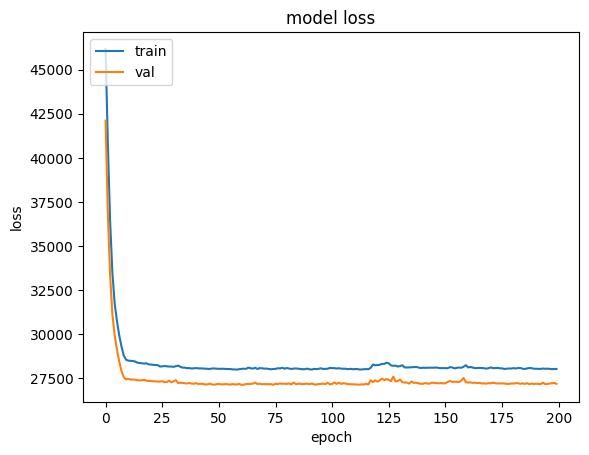

In [40]:
plt.plot(qmodel_history.history['loss'])
plt.plot(qmodel_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# search with keras tuner

In [ ]:
import keras_tuner

In [ ]:
def build_model(hp):
    act_total_bits = hp.Int("act_total_bits", min_value=2, max_value=16, step=2)
    act_int_bits = hp.Int(" act_int_bits", min_value=0, max_value=act_total_bits-1, step=1)
    qgru_total_bits = hp.Int("qgru_total_bits", min_value=2, max_value=16, step=2)
    qgru_int_bits = hp.Int("qgru_int_bits", min_value=0, max_value=qgru_total_bits-1, step=1)
    qgru_sigmoid_bits = hp.Int("qgru_sigmoid_bits", min_value=2, max_value=16, step=2)
    qgru_tanh_bits = hp.Int("qgru_tanh_bits", min_value=2, max_value=16, step=2)
    #activation = hp.Choice("activation", ["relu", "tanh"])
    #dropout = hp.Boolean("dropout")
    #dropout = hp.Float("drop", min_value=0.05, max_value=0.2, step=0.05)
    
    # call existing model-building code with the hyperparameter values.
    model = create_model(
                        act_total_bits = act_total_bits,
                        act_int_bits = act_int_bits,
                        qgru_total_bits=qgru_total_bits, 
                         qgru_int_bits=qgru_int_bits, 
                         qgru_sigmoid_bits=qgru_sigmoid_bits, 
                         qgru_tanh_bits=qgru_tanh_bits, 
                         drop=dropout, 
                         )
    
    model.compile(
    loss = poisson_loglike_loss,
    optimizer = optimizer
    )
    return model


build_model(keras_tuner.HyperParameters())

In [ ]:
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=100,
    executions_per_trial=2, #reduce results variance
    overwrite=True,
    directory="Q_RAE",
    project_name="Keras_Tuner_Q_RAE",
)


In [ ]:
tuner.search_space_summary()

In [ ]:
tuner.search([x_train, inputs2decoder_train], x_train, batch_size = 16, epochs=5, validation_data=([x_val, inputs2decoder_val], x_val))

In [ ]:
tuner.results_summary()

In [ ]:
# Get the top 2 hyperparameters.
best_hps = tuner.get_best_hyperparameters(2)
# Build the model with the best hp.
model_best = build_model(best_hps[0])

In [ ]:
from qkeras.autoqkeras.utils import print_qmodel_summary

In [ ]:
print_qmodel_summary(model_best)

# Retrain

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="q_rae.h5",
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:
model_best_history = model_best.fit([x_train, inputs2decoder_train], 
               y_train, 
               batch_size = 16, 
               epochs=100, 
               validation_data=([x_val, inputs2decoder_val], y_val),
               callbacks = model_checkpoint_callback
              
              )


In [ ]:
model_best_history2 = model_best.fit([x_train, inputs2decoder_train], 
               y_train, 
               batch_size = 16, 
               epochs=100, 
               validation_data=([x_val, inputs2decoder_val], y_val),
               callbacks = model_checkpoint_callback
              
              )

# Train fp model

In [ ]:
from tensorflow.keras.layers import Dense, GRU

In [ ]:
def get_fp_model(drop = 0.05, initializer=None, regularizer=None):
    inputLayer =  Input(shape=(73,70))
    x = Dropout(drop, name = 'initial_dropout')(inputLayer)
    x = Bidirectional(GRU(64, time_major=False, 
                            return_state=True, kernel_regularizer=regularizer, 
                            kernel_initializer=initializer), 
                        backward_layer=GRU(64, time_major=False, 
                                           return_state=True, go_backwards=True, 
                                           kernel_regularizer=regularizer, kernel_initializer=initializer), 
                        merge_mode='concat', name = 'Encoder_BidirectionalGRU')(x)[0]
    x = Dropout(drop, name = 'postencoder_dropout')(x)
    x = Dense(64, kernel_regularizer=regularizer, kernel_initializer=initializer, name='dense_mean')(x)

    input_decoder = Input(shape=(73, 64))
    x = GRU(64, return_sequences=True, 
          time_major=False, kernel_initializer=initializer, 
          kernel_regularizer=regularizer, name='decoder_GRU')(input_decoder, initial_state = x)
    x = Dropout(drop, name = 'postdecoder_dropout')(x)
    out = Dense(2, use_bias = False, kernel_regularizer=regularizer, kernel_initializer=initializer, name='dense')(x)

    model = Model(inputs = [inputLayer,input_decoder], outputs = out)
    model.compile(
        optimizer="adam", loss="mean_squared_error",
    )
    return model

In [ ]:
fp_model = get_fp_model(0.05)

In [ ]:
fp_model.summary()

In [ ]:
fp_model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="fp_rae.h5",
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:
fp_model_history = fp_model.fit([x_train, inputs2decoder_train], 
               y_train, 
               batch_size = 16, 
               epochs=100, 
               validation_data=([x_val, inputs2decoder_val], y_val),
               callbacks = fp_model_checkpoint_callback
              
              )


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Flatten, GRU, Activation, Embedding, Bidirectional, Flatten, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import Model
import hls4ml
import numpy as np




initializer = tf.keras.initializers.VarianceScaling(distribution='normal')
regularizer = tf.keras.regularizers.L2(l=1)
inputs2model = test_neural_data # 17, 73, 70
inputDim = 136
inputs2decoder = tf.stack([tf.zeros_like(inputs2model)[:, :, -1]
            for i in range(64)], axis=-1)

# if isinstance(inputs2model, np.ndarray):
#   print("inputs2model IS numpy array")
# else:
#   print("inputs2model IS NOT numpy array")

# if isinstance(inputs2decoder, np.ndarray):
#   print("inputs2decoder IS numpy array")
# else:
#   print("inputs2decoder IS NOT numpy array")

# if isinstance(inputs2decoder, list):
#   print("inputs2decoder IS list")
# else:
#   print("inputs2decoder IS NOT list")

inputs2decoder_np = np.array(inputs2decoder)

if isinstance(inputs2decoder, np.ndarray):
  print("inputs2decoder IS numpy array")
else:
  print("inputs2decoder IS NOT numpy array")

# inputs2decoder = np.zeros((17,73,64))
def create_model(inputs2model, inputs2decoder, initializer, regularizer):
  
  inputLayer =  Input(shape=inputs2model[0].shape)
  x = Dropout(0.05, name = 'initial_dropout')(inputLayer)
  x = Bidirectional(GRU(64, time_major=False, 
                        return_state=True, kernel_regularizer=regularizer, 
                        kernel_initializer=initializer), 
                    backward_layer=GRU(64, time_major=False, 
                                       return_state=True, go_backwards=True, 
                                       kernel_regularizer=regularizer, kernel_initializer=initializer), 
                    merge_mode='concat', name = 'Encoder_BidirectionalGRU')(x)[0]
  x = Dropout(0.05, name = 'postencoder_dropout')(x)
  x = Dense(64, kernel_regularizer=regularizer, kernel_initializer=initializer, name='dense_mean')(x)
  input_decoder = Input(shape=inputs2decoder[0].shape)
  x = GRU(64, return_sequences=True, 
          time_major=False, kernel_initializer=initializer, 
          kernel_regularizer=regularizer, name='decoder_GRU')(input_decoder, initial_state = x)
  x = Dropout(0.05, name = 'postdecoder_dropout')(x)
  z = Dense(4, use_bias = False, kernel_regularizer=regularizer, kernel_initializer=initializer, name='dense')(x)
  log_f = Dense(70, kernel_regularizer=regularizer, kernel_initializer=initializer, name='nerual_dense')(z)
  # z = Flatten()(z)
  # temp_1 = Dense(5,name='dense_temp1')(z)
  # log_f = Flatten()(log_f)
  # temp_2 = Dense(5,name='dense_temp2')(log_f)
  out = Concatenate()([z,log_f])

 # return Model(inputs = [inputLayer,input_decoder], outputs =[z, log_f])
  return Model(inputs = [inputLayer,input_decoder], outputs =out)

LFADs_keras = create_model(inputs2model,inputs2decoder, initializer, regularizer)
# LFADs_keras.summary()
LFADs_keras.compile()

LFADs = tf.keras.models.load_model("/home/xiaohan/HLS4ML_side_branch/hls4ml/test_LFADs/3_3.h5")
# LFADs.summary()

LFADs_keras.layers[2].set_weights(LFADs.layers[2].get_weights())
LFADs_keras.layers[5].set_weights(LFADs.layers[5].get_weights())
LFADs_keras.layers[6].set_weights(LFADs.layers[6].get_weights())
LFADs_keras.layers[8].set_weights(LFADs.layers[8].get_weights())
LFADs_keras.layers[9].set_weights(LFADs.layers[9].get_weights())

lfads_out = LFADs_keras.predict([inputs2model, inputs2decoder_np])
print("lfads_out prediction by keras is:")
print(lfads_out.shape)

config = hls4ml.utils.config_from_keras_model(LFADs_keras, granularity='model', default_precision='ap_fixed<32,16>')
print("-----------------------------------")
print("Configuration")
'''plotting.print_dict(config)'''
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(LFADs_keras,
                                                       hls_config=config,
                                                       output_dir='/home/xiaohan/HLS4ML_side_branch/hls4ml/test_LFADs',
                                                       part='xc7v2000tflg1925-2')
print("done")
hls_model.compile()
hls_out = hls_model.predict([inputs2model, inputs2decoder_np])
hls_out = np.reshape(hls_out, (17,73,74))
print(hls_out)
#hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)
# hls_model.build(csim=False)
hls_out_z = hls_out[:,:,:4]
hls_out_log_f = hls_out[:,:,4:]
print(hls_out_z.shape)
print(hls_out_log_f.shape)
print("z", hls_out_z)
print("log_f",hls_out_log_f)
np.savetxt("/home/xiaohan/HLS4ML_side_branch/hls4ml/test_LFADs/hls_out_z_32_16.txt", hls_out_z.reshape((-1, hls_out_z.shape[-1])))
np.savetxt("/home/xiaohan/HLS4ML_side_branch/hls4ml/test_LFADs/hls_out_log_f_32_16.txt", hls_out_log_f.reshape((-1, hls_out_log_f.shape[-1])))

In [ ]:
np.random.seed(3)
input_shape = (73, 70)  # Shape of the 'inputs' tensor 
# input_shape = (5, 2) # for testing
batch_size = 136  # Batch size
inputs_data = np.random.rand(batch_size, *input_shape)
# print(inputs_data)
load_test_data = np.loadtxt("/home/xiaohan/HLS4ML_side_branch/hls4ml/test_LFADs/test_nerual_data.txt")
test_neural_data = load_test_data.reshape((17,73,70))
print(test_neural_data.shape)

In [ ]:


# center behaviour at zero, using first time step (not strictly required)
b_mean = np.mean(np.vstack((behavioural_data, test_behavioural_data, valid_behavioural_data))[:,0,:],axis=0)
for i in range(2):
    behavioural_data[:,:,i] = behavioural_data[:,:,i]-b_mean[i]
    valid_behavioural_data[:,:,i] = valid_behavioural_data[:,:,i]-b_mean[i]
    test_behavioural_data[:,:,i] = test_behavioural_data[:,:,i]-b_mean[i]

# for plotting
d_all = np.concatenate((dataset['train_target_direction'], dataset['test_target_direction'], dataset['valid_target_direction']))
d = dataset['train_target_direction']
direction_index_train = np.array([sorted(set(d_all)).index(i) for i in d])
d = dataset['test_target_direction']
direction_index_test = np.array([sorted(set(d_all)).index(i) for i in d])
direction_index_all = np.concatenate((direction_index_test, direction_index_train))

In [ ]:
behavioural_data.max()

In [ ]:
# model parameters

# l2 regulariser for the recurrent decoder weights
l2_reg = .1
initial_neural_weight = 1.0 # weight of neural nll
initial_behaviour_weight = .2 # weight of behaviour loss
lambda_q = 100.0
update_rate = .0005
dropout = .15
seed = 0
GRU_pre_activation = False
var_min = 0.0001
prior_variance = 1

optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-2,
    beta_1=0.9, 
    beta_2=0.999,
    epsilon=1e-08)

layers_settings=defaultdict(lambda: dict(
    kernel_initializer=tf.keras.initializers.VarianceScaling(
        scale=1.0, mode='fan_in', distribution='normal'),
    kernel_regularizer=tf.keras.regularizers.l2(l=0.0)
))

layers_settings['encoder'].update(dict(var_min=var_min, var_trainable=True))
layers_settings['decoder'].update(dict(kernel_regularizer=tf.keras.regularizers.l2(l=0),
                                      recurrent_regularizer=tf.keras.regularizers.l2(l=l2_reg),
                                      original_cell=False))    

# for Qkeras
# 8 bits

In [ ]:
layers_settings['quantizer'] = "quantized_bits(8,0,1,alpha=1.0)"

In [ ]:
T = datetime.today().strftime("%y_%m_%d_%X")

logdir = os.path.join( spike_data_dir, 'lfads_log_l2_reg_'+str(l2_reg)+'_'+T)
modeldir = os.path.join( spike_data_dir, 'lfads_model_l2_reg_'+str(l2_reg)+'_'+T)

In [ ]:
T0 = datetime.now()

model, history, x_train, y_train, (x_test, y_test) = Runtime.train(
    model_type=ModelType.LFADS,
    adaptive_lr=dict(factor=0.95, patience=10, min_lr=1e-5),
    model_settings=dict(
        factors=4,
        encoded_dim=64,
        max_grad_norm=200,
        dropout=dropout,
        prior_variance=prior_variance,
        GRU_pre_activation=GRU_pre_activation, #NEW
        timestep=settings['step'],
        seed=seed
    ),
    layers_settings=layers_settings,
    optimizer=optimizer, 
    epochs=1, 
    logdir=logdir,
    train_dataset=(neural_data, behavioural_data), 
    val_dataset=(valid_neural_data, valid_behavioural_data),
    adaptive_weights=AdaptiveWeights(
        initial=[initial_neural_weight, initial_behaviour_weight, .0, .0, lambda_q, .0], #changed
        update_start=[0, 0, 0, 1000, 1000, 0],
        update_rate=[0., 0., update_rate, update_rate, 0.0, update_rate],
        min_weight=[initial_neural_weight, initial_behaviour_weight, 0.0, 0.0, lambda_q, 0.0],#changed
        max_weight=[initial_neural_weight, initial_behaviour_weight, 1.0, 1.0, lambda_q, 1.0],#changed
    ),
    batch_size=16,
    verbose=2 # set to 2 to see the losses during training
)

#model.save(modeldir)

print('Training took '+str(datetime.now()-T0))

In [ ]:
neural_data.shape

In [ ]:
decodergru = model.layers[7]

In [ ]:
decodergru.__dict__

In [ ]:
decodergru.cell.__dict__

In [ ]:
decodergru.cell.activation

In [ ]:
decodergru.cell.recurrent_quantizer

In [ ]:
model.summary()

# Rebuild 

In [ ]:
from qkeras import QGRU, QDense
from tensorflow.keras.layers import Bidirectional, Dropout, RNN, Input

In [ ]:
tensor_in = Input(shape = neural_data.shape[1:])

In [ ]:
x = tensor_in

In [ ]:
def create_model(inputs2model, inputs2decoder, initializer, regularizer):
  
  inputLayer =  Input(shape=inputs2model[0].shape)
  x = Dropout(0.05, name = 'initial_dropout')(inputLayer)
  x = Bidirectional(GRU(64, time_major=False, 
                        return_state=True, kernel_regularizer=regularizer, 
                        kernel_initializer=initializer), 
                    backward_layer=GRU(64, time_major=False, 
                                       return_state=True, go_backwards=True, 
                                       kernel_regularizer=regularizer, kernel_initializer=initializer), 
                    merge_mode='concat', name = 'Encoder_BidirectionalGRU')(x)[0]
  x = Dropout(0.05, name = 'postencoder_dropout')(x)
  x = Dense(64, kernel_regularizer=regularizer, kernel_initializer=initializer, name='dense_mean')(x)
  input_decoder = Input(shape=inputs2decoder[0].shape)
  x = GRU(64, return_sequences=True, 
          time_major=False, kernel_initializer=initializer, 
          kernel_regularizer=regularizer, name='decoder_GRU')(input_decoder, initial_state = x)
  x = Dropout(0.05, name = 'postdecoder_dropout')(x)
  z = Dense(4, use_bias = False, kernel_regularizer=regularizer, kernel_initializer=initializer, name='dense')(x)
  log_f = Dense(70, kernel_regularizer=regularizer, kernel_initializer=initializer, name='nerual_dense')(z)
  # z = Flatten()(z)
  # temp_1 = Dense(5,name='dense_temp1')(z)
  # log_f = Flatten()(log_f)
  # temp_2 = Dense(5,name='dense_temp2')(log_f)
  out = Concatenate()([z,log_f])

 # return Model(inputs = [inputLayer,input_decoder], outputs =[z, log_f])
  return Model(inputs = [inputLayer,input_decoder], outputs =out)

LFADs_keras = create_model(inputs2model,inputs2decoder, initializer, regularizer)

# Latent space

## Training data

In [ ]:
log_f, (g0, mean, logvar), z =  model(neural_data.astype('float'), training=False)

In [ ]:
z.shape

In [ ]:
behavioural_data.shape

In [ ]:
# latent variables

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

plt.figure(figsize=(8,7))
plt.subplot(221)
proj = PCA(n_components=2, whiten=True).fit_transform(mean)
plt.scatter(proj[:,0], proj[:,1], alpha=.8, color=direction_colors[direction_index_train])
plt.axis('equal')
plt.xlabel('PCA factor 1')
plt.ylabel('PCA factor 2')
plt.title('Factors')

plt.subplot(222)
ics_embedded = TSNE(n_components=2, n_jobs=2, random_state=12).fit_transform(mean)
plt.scatter(ics_embedded[:,0], ics_embedded[:,1], alpha=.8, color=direction_colors[direction_index_train])
plt.axis('equal')
plt.xlabel('T-SNE factor 1')
plt.ylabel('T-SNE factor 2')
plt.title('Factors')


In [ ]:
# latent factors
plt.figure(figsize=(6,6))
plot_all_2factors(z, direction_index_train)
plt.figure(figsize=(8,1.5))
plot_all_1factors(z, direction_index_train)


In [ ]:
from sklearn.linear_model import Ridge
factors_reconstruct = np.arange(4)

X = np.transpose(z.numpy()[:,:,factors_reconstruct], (0,2,1)).reshape((z.shape[0], -1))
y = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))

Xt = X
yt = y

reg = Ridge(normalize=True, fit_intercept=True).fit(X, y)
print(reg.score(Xt, yt))
beh_fit = reg.predict(Xt)
b = np.zeros_like(behavioural_data)
b[:,:,0] = beh_fit[:,:behavioural_data.shape[1]]
b[:,:,1] = beh_fit[:,behavioural_data.shape[1]:]

In [ ]:
# behaviour reconstruction
plt.figure(figsize=(6,6));
plot_behaviour(b, behavioural_data, direction_index_train, num=20)

In [ ]:
Xt = np.transpose(b, (0,2,1)).reshape((b.shape[0], -1))
yt = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))
print('R2 score behaviour: {:.3%}'.format(r2_score( yt, Xt)))

## Test data

In [ ]:
log_f_t, (g0_t, mean_t, logvar_t), z_t = \
    model(test_neural_data.astype('float'), training=False)

In [ ]:
# latent variables

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

plt.figure(figsize=(12,7))
plt.subplot(221)
proj = PCA(n_components=2, whiten=True).fit_transform(np.vstack((mean,mean_t)))
plt.scatter(proj[:,0], proj[:,1], alpha=.8, color=direction_colors[np.concatenate((direction_index_train, direction_index_test))])
plt.axis('equal')
plt.ylabel('PCA factor 2')
plt.title('Factors')

plt.subplot(222)
ics_embedded = TSNE(n_components=2, n_jobs=2, random_state=12).fit_transform(np.vstack((mean,mean_t)))
plt.scatter(ics_embedded[:,0], ics_embedded[:,1], alpha=.8, color=direction_colors[np.concatenate((direction_index_train, direction_index_test))])
plt.axis('equal')
plt.ylabel('T-SNE factor 2')
plt.title('Factors')


In [ ]:
# relevant factors
plt.figure(figsize=(6,6))
plot_all_2factors(z_t, direction_index_test)
# relevant factors
plt.figure(figsize=(8,1.5))
plot_all_1factors(z_t, direction_index_test)


In [ ]:
from sklearn.linear_model import Ridge
factors_reconstruct = np.arange(4)

X = np.transpose(z.numpy()[:,:,factors_reconstruct], (0,2,1)).reshape((z.shape[0], -1))
y = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))

Xt = np.transpose(z_t.numpy()[:,:,factors_reconstruct], (0,2,1)).reshape((z_t.shape[0], -1))
yt = np.transpose(test_behavioural_data, (0,2,1)).reshape((test_behavioural_data.shape[0], -1))

reg = Ridge(normalize=True, fit_intercept=True).fit(X, y)
print(reg.score(Xt, yt))
beh_fit = reg.predict(Xt)
b_t = np.zeros_like(test_behavioural_data)
b_t[:,:,0] = beh_fit[:,:test_behavioural_data.shape[1]]
b_t[:,:,1] = beh_fit[:,test_behavioural_data.shape[1]:]

In [ ]:
# behaviour reconstruction
plt.figure(figsize=(6,6));
plot_behaviour(b_t, test_behavioural_data, direction_index_test, num=100)
# plot_behaviour(b, behavioural_data, direction_index_train)

In [ ]:
Xt = np.transpose(b_t, (0,2,1)).reshape((b_t.shape[0], -1))
yt = np.transpose(test_behavioural_data, (0,2,1)).reshape((test_behavioural_data.shape[0], -1))
print('R2 score behaviour: {:.3%}'.format(r2_score( yt, Xt)))

# Trial-averaged firing rates and predictions
Computed from test+train data for better averages

In [ ]:
from sklearn.metrics import mean_squared_error
fig = plt.figure(figsize=(16,10))
colors = plt.cm.nipy_spectral(np.arange(8)/8)
a = []
for i in range(8):
    data = np.vstack((test_neural_data, neural_data))[direction_index_all==i,:,:]

    for i_n,n in enumerate(range(0,70)):
        ax = fig.add_subplot(8, 70, i*70+i_n+1)
        pred = np.vstack((np.exp(log_f_t)*settings['step'], np.exp(log_f)*settings['step']))[np.array(direction_index_all)==i,:,n]
        x = np.arange(data.shape[1])
        ax.plot(x,np.mean(data,axis=0)[:,n],'k',alpha=0.5);
        data_mean = np.mean(data,axis=0)
        data_mean_test = np.mean(data,axis=0)[:,n]
#         print("n",n)
#         print(pred.shape)
#         print(data_mean_test.shape)
        
        ax.fill_between(x,np.mean(data,axis=0)[:,n]-np.std(data,axis=0)[:,n], np.mean(data,axis=0)[:,n]+np.std(data,axis=0)[:,n], alpha=0.2, color='k');
        ax.plot(x,np.mean(pred,axis=0),lw=3, color=colors[i]);
        pred_test = np.mean(pred,axis=0)
#         print(pred_test.shape)

        ax.set_xticks(())
        ax.set_yticks(())
        plt.ylim(0,1.5)
        
        data4mse = data_mean_test
        pred4mse = pred_test
        diff = mean_squared_error(data4mse,pred4mse)
        a.append(diff)
        


In [ ]:
print(sum(a) / len(a))
print(max(a))
print(min(a))
print(log_f.shape)

In [ ]:
d_all = dataset['test_target_direction']

d = dataset['test_target_direction']
direction_index_test = np.array([sorted(set(d_all)).index(i) for i in d])
direction_index_all =direction_index_test
print(direction_index_all.shape)